# East coast floods


In [59]:
import os
import datetime
import glob

from collections import Counter
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cartopy
import cartopy.crs as ccrs
import geopandas as gp
from IPython.display import Image
from scipy.stats import genextreme as gev
import xclim as xc
import cmocean
import seaborn as sns

from unseen import fileio
from unseen import general_utils
from unseen import time_utils

In [2]:
# Optional parameters 
# (This cell is tagged "parameters")
dpi = 300

In [3]:
# Parameters
agcd_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_AGCD-CSIRO_r005_1900-2022_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region.zarr.zip"
model_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_bc_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_bias-corrected-AGCD-CSIRO-multiplicative.zarr.zip"
similarity_raw_file = "/g/data/xv83/dbi599/east-coast-rain/data/similarity-test_Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region_AGCD-CSIRO.zarr.zip"
independence_plot = "/g/data/xv83/dbi599/east-coast-rain/figures/independence-test_Rx15day_CanESM5-dcppA-hindcast_196101-201701_annual-aug-to-sep_east-coast-flood-region.png"
model_name = "CanESM5"
min_lead = 1
region_name = "east-coast-flood-region"
shape_file = "/g/data/xv83/dbi599/east-coast-rain/shapefiles/east-coast-flood.shp"
file_list = "file_lists/CanESM5_dcppA-hindcast_files.txt"
nino_file = "/g/data/xv83/dbi599/east-coast-rain/data/nino34-anomaly_CanESM5-dcppA-hindcast_196101-201701_base-196101-201701.zarr.zip"


In [4]:
# Required parameters
assert 'model_name' in locals(), "Must provide a model name"
assert 'region_name' in locals(), "Must provide a region name"
assert 'min_lead' in locals(), "Must provide a minimum lead time"
assert os.path.isfile(file_list), "Must provide the input model files list (papermill option -p file_list [filepath])"
assert os.path.isfile(shape_file), "Must provide the shapefile (papermill option -p shape_file [filepath])"
assert os.path.isfile(agcd_file), "Must provide an AGCD data file (papermill option -p agcd_file [filepath])"
assert os.path.isfile(model_file), "Must provide an model data file (papermill option -p cafe_file [filepath])"
assert os.path.isfile(model_bc_file), "Must provide a model bias corrected data file (papermill option -p cafe_bc_file [filepath])"
assert os.path.isfile(nino_file), "Must provide a model Nino 3.4 data file (papermill option -p nino_file [filepath])"
assert os.path.isfile(similarity_bc_file), "Must provide an bias corrected similarity test file (papermill option -p similarity_bias_file [filepath])"
assert os.path.isfile(similarity_raw_file), "Must provide an raw data similarity test file (papermill option -p similarity_raw_file [filepath])"
assert os.path.isfile(independence_plot), "Must provide an independence test plot (papermill option -p independence_plot [filepath])"

## Observations

In [5]:
agcd_ds = fileio.open_dataset(agcd_file)
agcd_ds = agcd_ds.dropna('time')

In [6]:
agcd_ds

<xarray.Dataset>
Dimensions:     (time: 122)
Coordinates:
    event_time  (time) <U28 dask.array<chunksize=(122,), meta=np.ndarray>
  * time        (time) object 1901-01-01 09:00:00 ... 2022-01-01 09:00:00
Data variables:
    pr          (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/33)
    CDI:                           Climate Data Interface version ?? (http://...
    CDO:                           Climate Data Operators version 1.7.0 (http...
    Conventions:                   CF-1.6
    acknowledgment:                The Australian Government, Bureau of Meteo...
    analysis_components:           total: the gridded accumulation of rainfall.
    bom-cmp-awap_version:          bom-cmp-awap-1.00-89.0.x86_64
    ...                            ...
    summary:                       The daily and monthly rainfall data repres...
    time_coverage_end:             1900-01-01T09:00:00
    time_coverage_start:           1899-12-31T09:00:00
    title:                         Interpolated Rain Gauge Precipitation
    url:                           http://www.bom.gov.au/climate/
    uuid:                          14333ae2-28fe-4cb6-9f00-677adc94f25e

In [7]:
years = agcd_ds['time'].dt.year.values
agcd_df = pd.DataFrame(index=years)
agcd_df['pr'] = agcd_ds['pr'].values

In [8]:
pr2022 = agcd_ds['pr'].values.max()
print(pr2022)

410.43057


## Model ensemble

### Region selection

In [9]:
with open(file_list) as f:
    all_files = f.read()
    first_file = all_files.split('\n', 1)[0]

In [10]:
first_file

'/g/data/oi10/replicas/CMIP6/DCPP/CCCma/CanESM5/dcppA-hindcast/s1960-r1i1p2f1/day/pr/gn/v20190429/pr_day_CanESM5_dcppA-hindcast_s1960-r1i1p2f1_gn_19610101-19701231.nc'

In [11]:
shapes = gp.read_file(shape_file)

In [12]:
isel_dict = {'time': 0}
if model_name == 'CAFE':
    isel_dict['ensemble'] = 0
    metadata_file = '/home/599/dbi599/unseen/config/dataset_cafe_daily.yml'
else:
    metadata_file = None

In [14]:
region_ds = fileio.open_dataset(
    first_file,
    metadata_file=metadata_file,
    variables=['pr'],
    lat_bnds=[-40, -20],
    lon_bnds=[140, 160],
    shapefile=shape_file,
    shape_overlap=0.1,
    units={'pr': 'mm day-1'},
    isel=isel_dict,
)

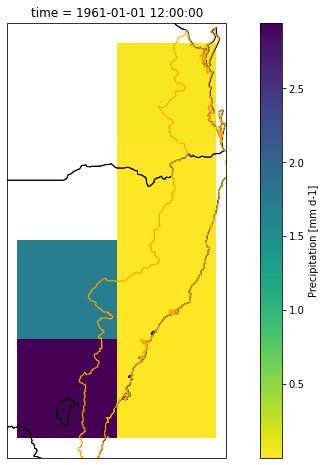

In [15]:
fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
region_ds['pr'].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='viridis_r',
)
ax.coastlines()
ax.add_feature(cartopy.feature.STATES)
ax.add_geometries(shapes.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='orange')
plt.show()

### Model data

In [16]:
model_ds = fileio.open_dataset(model_file)
model_bc_ds = fileio.open_dataset(model_bc_file)

In [17]:
model_ds

<xarray.Dataset>
Dimensions:     (ensemble: 20, init_date: 57, lead_time: 11)
Coordinates:
  * ensemble    (ensemble) int64 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19
    event_time  (init_date, ensemble, lead_time) <U28 dask.array<chunksize=(57, 20, 11), meta=np.ndarray>
  * init_date   (init_date) object 1961-01-01 00:00:00 ... 2017-01-01 00:00:00
  * lead_time   (lead_time) int64 0 1 2 3 4 5 6 7 8 9 10
    time        (lead_time, init_date) object dask.array<chunksize=(11, 57), meta=np.ndarray>
Data variables:
    pr          (init_date, ensemble, lead_time) float64 dask.array<chunksize=(1, 1, 11), meta=np.ndarray>
Attributes: (12/53)
    CCCma_model_hash:            Unknown
    CCCma_parent_runid:          d2a-asm-e01
    CCCma_pycmor_hash:           13db8596c37129e414cad7ae31f2927ca8f5dd39
    CCCma_runid:                 d2a196101e01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1961:01:01:00
    ...                          ...
    table_info:                  Creation Date:(20 February 2019) MD5:374fbe5...
    title:                       CanESM5 output prepared for CMIP6
    tracking_id:                 hdl:21.14100/f220e01c-1214-4625-be6a-c0475c2...
    variable_id:                 pr
    variant_label:               r1i1p2f1
    version:                     v20190429

### Independence testing

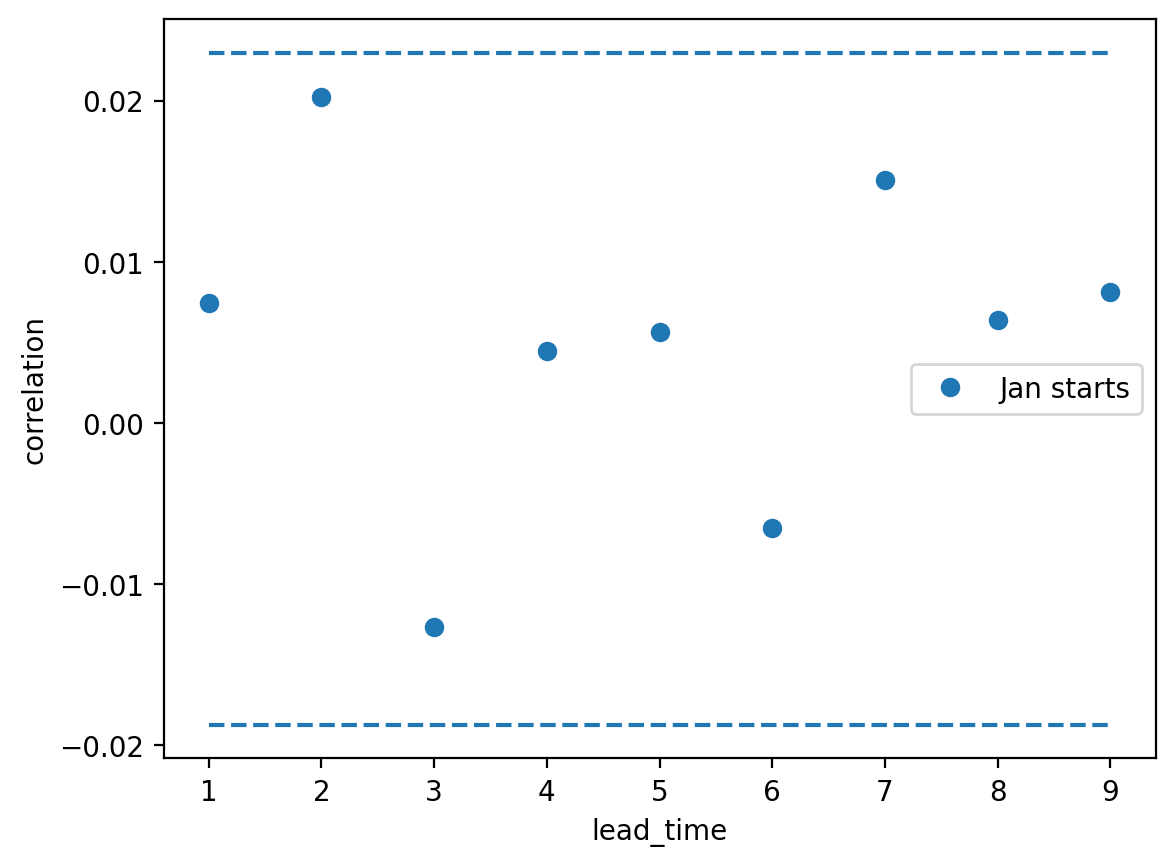

In [18]:
Image(filename=independence_plot)

In [19]:
print(min_lead)

1


In [20]:
model_da = model_ds['pr'].where(model_ds['lead_time'] >= min_lead)

### Bias correction and similarity testing

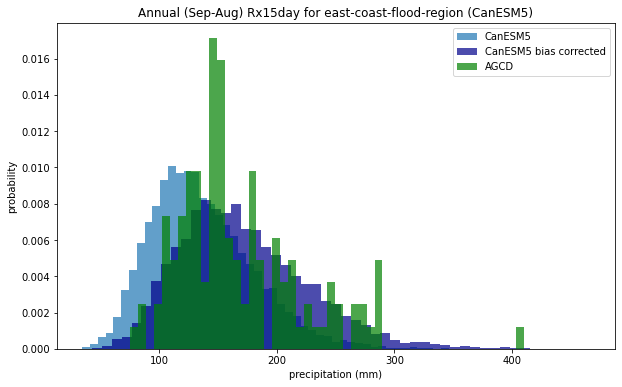

In [21]:
fig = plt.figure(figsize=[10, 6])
model_da.plot.hist(bins=50, density=True, label=model_name, alpha=0.7)
model_bc_ds['pr'].plot.hist(bins=50, density=True, label=f'{model_name} bias corrected', facecolor='darkblue', alpha=0.7)
agcd_ds['pr'].plot.hist(bins=50, density=True, label='AGCD', facecolor='green', alpha=0.7)
plt.xlabel('precipitation (mm)')
plt.ylabel('probability')
plt.title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
plt.legend()
plt.savefig(f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_histogram_{model_name}_{region_name}.png',
            bbox_inches='tight', facecolor='white', dpi=dpi)
plt.show()

We can look at p-values for the KS-test and Anderson-Darling test for each lead time.

p > 0.05 means the null hypothesis (that the two samples are from the same population) can't be rejected.

In [22]:
similarity_raw_ds = fileio.open_dataset(similarity_raw_file)

In [23]:
similarity_raw_ds['ks_pval'].values

array([1.7429718e-04, 1.4695530e-07, 1.3272067e-05, 1.3272067e-05,
       1.9570916e-05, 1.2313030e-04, 2.3165255e-04, 1.3053347e-04,
       1.8457005e-04], dtype=float32)

In [24]:
similarity_raw_ds['ad_pval'].values

array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
      dtype=float32)

In [25]:
similarity_bias_ds = fileio.open_dataset(similarity_bc_file)

In [26]:
similarity_bias_ds['ks_pval'].values

array([0.6718141 , 0.5954469 , 0.6718141 , 0.60629386, 0.60629386,
       0.6718141 , 0.3946323 , 0.7044636 , 0.52105194], dtype=float32)

In [27]:
similarity_bias_ds['ad_pval'].values

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25],
      dtype=float32)

### Exceedance curves

In [28]:
def plot_exceedance(sample_ds, model_name, outfile=None):
    """Plot single exceedance curve"""
    
    sorted_data, exceedance_data = general_utils.exceedance_curve(sample_ds)
    
    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    ax.plot(sorted_data, exceedance_data)
    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.axvline(pr2022, color='0.5', linestyle='--')
    if outfile:
        plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
        print(outfile)
    else:
        plt.show()

In [29]:
def plot_exceedance_by_decade(sample_ds, model_name):
    """Plot exceedance curve by decade"""

    fig = plt.figure(figsize=[8, 6])
    ax = fig.add_subplot()
    if model_name == 'CAFE':
        start_years = [1995, 2000, 2005, 2010, 2015]
        step = 4
    else:
        start_years = [1960, 1970, 1980, 1990, 2000, 2010]
        step = 9
    colors = iter(plt.cm.hot_r(np.linspace(0.3, 1, len(start_years))))

    for start_year in start_years:
        end_year = start_year + step
        start_date = f'{start_year}-01-01'
        end_date = f'{end_year}-12-25'
        ds_selection = time_utils.select_time_period(sample_ds, [start_date, end_date])
        ds_selection = ds_selection.dropna('sample')
        sorted_data, exceedance_data = general_utils.exceedance_curve(ds_selection)
        n_years = len(sorted_data)
        label = f'{start_year}-{end_year} ({n_years} samples)'
        color = next(colors)
        ax.plot(sorted_data, exceedance_data, label=label, color=color)
    
        print(f'{start_year}-{end_year}')
        n_events, n_population, return_period, percentile = general_utils.event_in_context(ds_selection.values, pr2022, 'above')
        print(f'{n_events} events in {n_population} samples')
        print(f'{percentile:.2f}% percentile')
        print(f'{return_period:.0f} year return period\n')

    ax.set_title(f'Annual (Sep-Aug) Rx15day for {region_name} ({model_name})')
    ax.set_ylabel('likelihood of exceedance (%)')
    ax.set_xlabel('Rx15day precipitation (mm)')
    ax.legend()
    ax.axvline(pr2022, color='0.5', linestyle='--')
    outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}_by-decade.png'
    plt.savefig(outfile, bbox_inches='tight', facecolor='white', dpi=dpi)
    print(outfile)

#### Bias corrected data

In [30]:
model_bc_da_stacked = model_bc_ds.dropna('lead_time')['pr'].stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [31]:
model_bc_da_stacked.shape

(10260,)

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_CanESM5.png


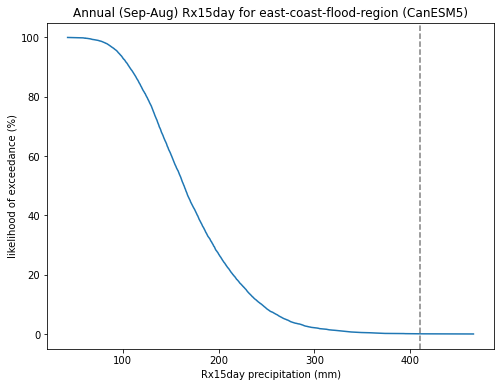

In [32]:
outfile = f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_{region_name}_{model_name}.png'
plot_exceedance(model_bc_da_stacked, model_name, outfile=outfile)

In [33]:
n_events_bc, n_population_bc, return_period_bc, percentile_bc = general_utils.event_in_context(model_bc_da_stacked.values, pr2022, 'above')
print('BIAS CORRECTED DATA')
print(f'{n_events_bc} events in {n_population_bc} samples')
print(f'{percentile_bc:.2f}% percentile')
print(f'{return_period_bc:.0f} year return period')

BIAS CORRECTED DATA
6 events in 10260 samples
99.94% percentile
1710 year return period


1960-1969


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 720 samples
100.00% percentile
inf year return period

1970-1979
2 events in 1800 samples
99.89% percentile
900 year return period

1980-1989
1 events in 1800 samples
99.94% percentile
1800 year return period

1990-1999
1 events in 1800 samples
99.94% percentile
1800 year return period

2000-2009


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


0 events in 1800 samples
100.00% percentile
inf year return period

2010-2019
2 events in 1780 samples
99.89% percentile
890 year return period

/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_precip_exceedence_east-coast-flood-region_CanESM5_by-decade.png


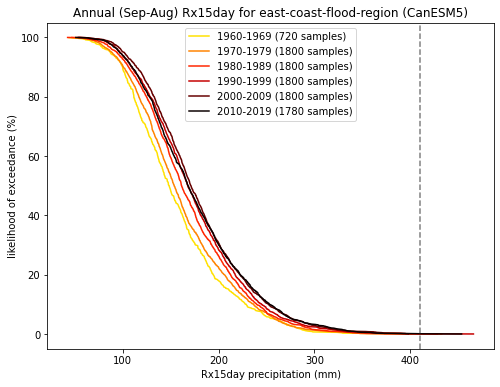

In [34]:
plot_exceedance_by_decade(model_bc_da_stacked, model_name)

#### Raw data

In [35]:
model_da_stacked = model_da.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [36]:
model_da_stacked.shape

(10260,)

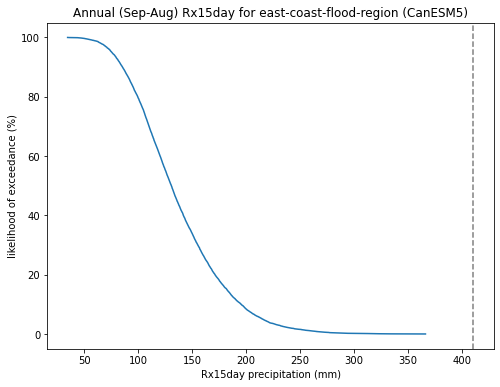

In [37]:
plot_exceedance(model_da_stacked, model_name)

In [38]:
n_events, n_population, return_period, percentile = general_utils.event_in_context(model_da_stacked.values, pr2022, 'above')
print('RAW DATA')
print(f'{n_events} events in {n_population} samples')
print(f'{percentile:.2f}% percentile')
print(f'{return_period:.0f} year return period')

RAW DATA
0 events in 10260 samples
100.00% percentile
inf year return period


/home/599/dbi599/unseen/unseen/general_utils.py:151: RuntimeWarning: divide by zero encountered in long_scalars
  return_period = n_population / n_events


### Seasonality

In [39]:
model_df = model_ds['pr'].to_dataframe()
model_df = model_df.dropna()
model_df = model_df.reset_index()
model_df

,init_date,ensemble,lead_time,event_time,time,pr
0,1961-01-01 00:00:00,0,1,1961-12-26,1962-01-01 12:00:00,81.595879
1,1961-01-01 00:00:00,0,2,1962-12-28,1963-01-01 12:00:00,133.093784
2,1961-01-01 00:00:00,0,3,1964-05-09,1964-01-01 12:00:00,162.798963
3,1961-01-01 00:00:00,0,4,1965-02-17,1965-01-01 12:00:00,126.662486
4,1961-01-01 00:00:00,0,5,1965-11-21,1966-01-01 12:00:00,88.175159
...,...,...,...,...,...,...
10255,2017-01-01 00:00:00,19,5,2022-05-20,2022-01-01 12:00:00,104.882119
10256,2017-01-01 00:00:00,19,6,2022-12-08,2023-01-01 12:00:00,117.623622
10257,2017-01-01 00:00:00,19,7,2024-03-02,2024-01-01 12:00:00,160.852820
10258,2017-01-01 00:00:00,19,8,2025-04-02,2025-01-01 12:00:00,165.083543


In [40]:
event_months = [int(date[5:7]) for date in model_df['event_time'].values]
event_years = [int(date[0:4]) for date in model_df['event_time'].values]

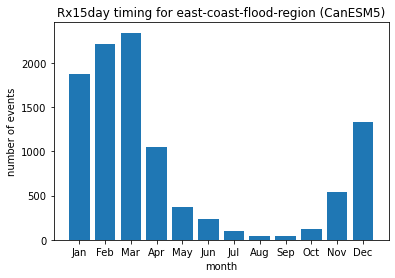

In [41]:
month_counts = Counter(event_months)
months = np.arange(1, 13)
counts = [month_counts[month] for month in months]

plt.bar(months, counts)
plt.title(f'Rx15day timing for {region_name} ({model_name})')
plt.ylabel('number of events')
plt.xlabel('month')
xlabels = [calendar.month_abbr[i] for i in months]
plt.xticks(months, xlabels)
#plt.savefig(
#    f'/g/data/xv83/dbi599/east-coast-rain/figures/Rx15day_timing_AGCD_{region_name}.png',
#    bbox_inches='tight',
#    facecolor='white',
#    dpi=dpi
#)
plt.show()

### Relationship with ENSO

In [42]:
nino_ds = fileio.open_dataset(nino_file)
nino_ds = nino_ds.assign_coords({'init_date': [date.strftime('%Y%m') for date in nino_ds['init_date'].values]})
nino_ds

<xarray.Dataset>
Dimensions:    (ensemble: 20, init_date: 57, lead_time: 120)
Coordinates:
  * ensemble   (ensemble) int64 0 1 2 3 4 5 6 7 8 ... 11 12 13 14 15 16 17 18 19
  * init_date  (init_date) <U6 '196101' '196201' '196301' ... '201601' '201701'
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 ... 113 114 115 116 117 118 119
    time       (lead_time, init_date) object dask.array<chunksize=(120, 57), meta=np.ndarray>
Data variables:
    tos        (init_date, ensemble, lead_time) float32 dask.array<chunksize=(1, 1, 120), meta=np.ndarray>
Attributes:
    history:  Mon Jan 30 10:33:00 2023: /g/data/xv83/dbi599/miniconda3/envs/u...

In [52]:
nino_values = []
for index, row in model_df.iterrows():
    event_init_date = row['init_date'].strftime('%Y%m')
    event_ensemble = row['ensemble']
    event_year_month = row['time'].strftime('%Y-%m')
    nino_selection = nino_ds.sel({'init_date': event_init_date, 'ensemble': event_ensemble})
    nino_selection = nino_selection.swap_dims({'lead_time': 'time'})
    nino_year_month = [date.strftime('%Y-%m') for date in nino_selection['time'].values]
    nino_selection = nino_selection.assign_coords({'time': nino_year_month})
    nino_value = float(nino_selection['tos'].sel({'time': event_year_month}).values)
    nino_values.append(nino_value)

In [53]:
model_df['nino34'] = nino_values

/g/data/xv83/dbi599/miniconda3/envs/unseen/lib/python3.9/site-packages/seaborn/distributions.py:1182: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(


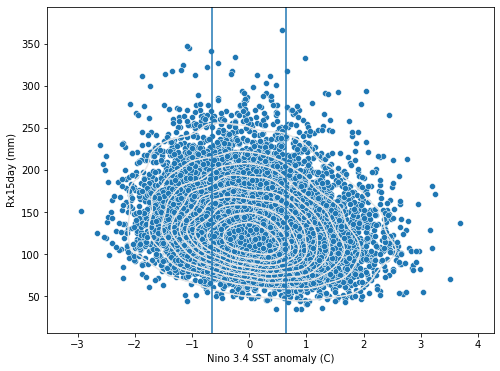

In [54]:
fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)

sns.scatterplot(ax=ax, data=model_df, x='nino34', y='pr')
sns.kdeplot(ax=ax, data=model_df, x='nino34', y='pr', color='0.9', linewidth=1)

ax.set_ylabel('Rx15day (mm)')
ax.set_xlabel('Nino 3.4 SST anomaly (C)')
ax.axvline(0.65)
ax.axvline(-0.65)
plt.show()

### Meteorology

In [55]:
def plot_average(color_da, color_var, contour_da, contour_var, start_date, end_date):
    """Plot average"""
    
    fig = plt.figure(figsize=[10, 5])
    map_proj=ccrs.PlateCarree(central_longitude=180)
    ax1 = fig.add_subplot(1, 1, 1, projection=map_proj)       
    
    if color_var == 'pr':
        levels = [0, 100, 200, 300, 400, 500, 600, 700, 800]
        label = 'total precipitation (mm)'
        cmap = cmocean.cm.rain
        extend = 'max'
    elif color_var == 'ua300':
        levels = [-30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30]
        label = '300hPa zonal wind'
        cmap='RdBu_r'
        extend = 'both'
    else:
        raise ValueError('Invalid color variable')
    color_da.plot(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        cmap=cmap,
        levels=levels,
        extend=extend,
        cbar_kwargs={'label': label},
    )
    
    if contour_var == 'z500':
        levels = np.arange(5000, 6300, 50)
    elif contour_var == 'psl':
        levels = np.arange(900, 1100, 2.5)
    elif contour_var == 'ua300':
        levels = np.arange(15, 60, 5)
    else:
        raise ValueError('Invalid contour variable')
    lines = contour_da.plot.contour(
        ax=ax1,
        transform=ccrs.PlateCarree(),
        levels=levels,
        colors=['0.1']
    )
    ax1.clabel(lines, colors=['0.1'], manual=False, inline=True)
    
    ax1.coastlines()
    ax1.set_extent([90, 205, -55, 10], crs=ccrs.PlateCarree())
    ax1.gridlines(linestyle='--', draw_labels=True)
    ax1.set_title(f'Average {contour_var} ({contour_da.units}), {start_date} to {end_date}')
#    plt.savefig(
#        f'/home/599/dbi599/east-coast-rain/{color_var}-{contour_var}_mean_BARRA2_{start_date}_{end_date}.png',
#        bbox_inches='tight',
#        facecolor='white',
#        dpi=300
#    )
    plt.show()

In [56]:
ranked_events = model_df.sort_values(by=['pr'], ascending=False)
ranked_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr,nino34
8312,2007-01-01 00:00:00,3,6,2013-03-04,2013-01-01 12:00:00,365.992317,0.583498
6337,1996-01-01 00:00:00,4,2,1998-02-01,1998-01-01 12:00:00,347.704310,-1.081697
913,1966-01-01 00:00:00,1,5,1971-02-27,1971-01-01 12:00:00,345.090720,-1.051418
2902,1977-01-01 00:00:00,2,5,1982-02-05,1982-01-01 12:00:00,341.560607,-0.672438
2144,1972-01-01 00:00:00,18,3,1975-02-06,1975-01-01 12:00:00,333.968198,-0.253229
8610,2008-01-01 00:00:00,16,7,2015-03-04,2015-01-01 12:00:00,332.670621,0.970613
8421,2007-01-01 00:00:00,15,7,2013-12-28,2014-01-01 12:00:00,326.524429,-0.546976
4756,1987-01-01 00:00:00,8,5,1992-03-12,1992-01-01 12:00:00,324.287687,-1.160715
6957,1999-01-01 00:00:00,13,1,2000-02-06,2000-01-01 12:00:00,322.712786,-0.728733
6458,1996-01-01 00:00:00,17,6,2002-02-12,2002-01-01 12:00:00,318.548660,-1.188860


In [57]:
model_bc_df = model_bc_ds['pr'].to_dataframe()
model_bc_df = model_bc_df.dropna()
model_bc_df = model_bc_df.reset_index()
ranked_bc_events = model_bc_df.sort_values(by=['pr'], ascending=False)
ranked_bc_events.head(n=10)

,init_date,ensemble,lead_time,event_time,time,pr
6337,1996-01-01 00:00:00,4,2,1998-02-01,1998-01-01 12:00:00,466.037506
8312,2007-01-01 00:00:00,3,6,2013-03-04,2013-01-01 12:00:00,453.683467
913,1966-01-01 00:00:00,1,5,1971-02-27,1971-01-01 12:00:00,432.867232
2902,1977-01-01 00:00:00,2,5,1982-02-05,1982-01-01 12:00:00,428.439207
2144,1972-01-01 00:00:00,18,3,1975-02-06,1975-01-01 12:00:00,421.443242
8610,2008-01-01 00:00:00,16,7,2015-03-04,2015-01-01 12:00:00,413.236878
4756,1987-01-01 00:00:00,8,5,1992-03-12,1992-01-01 12:00:00,406.772785
8421,2007-01-01 00:00:00,15,7,2013-12-28,2014-01-01 12:00:00,405.602200
624,1964-01-01 00:00:00,9,4,1968-02-16,1968-01-01 12:00:00,401.677735
7519,2002-01-01 00:00:00,15,5,2007-01-27,2007-01-01 12:00:00,398.186606


2006 (2013-03-04), ensemble: r4, 365.992316591472mm


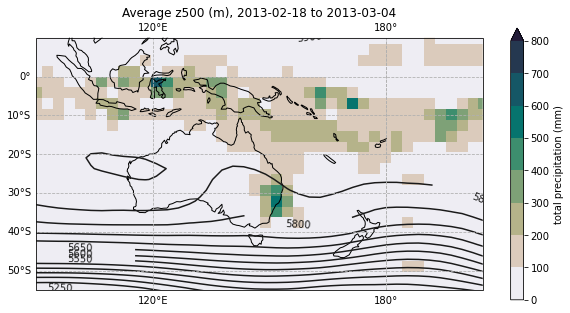

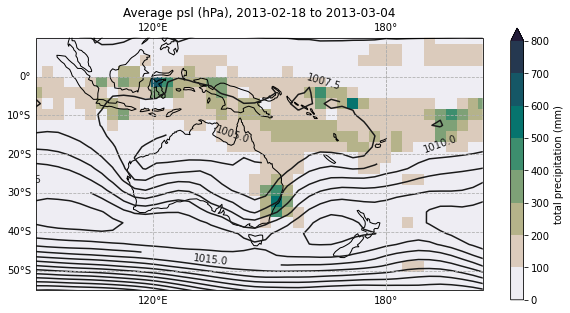

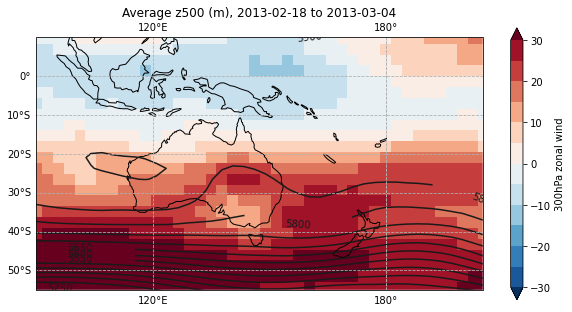

1995 (1998-02-01), ensemble: r5, 347.704309584546mm


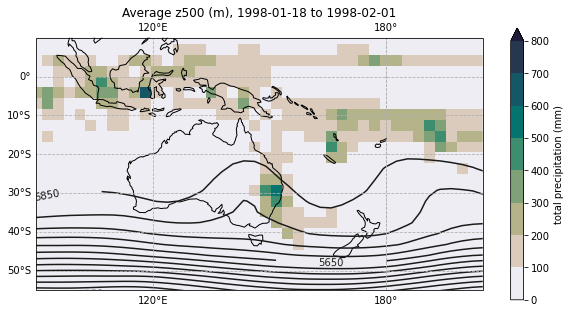

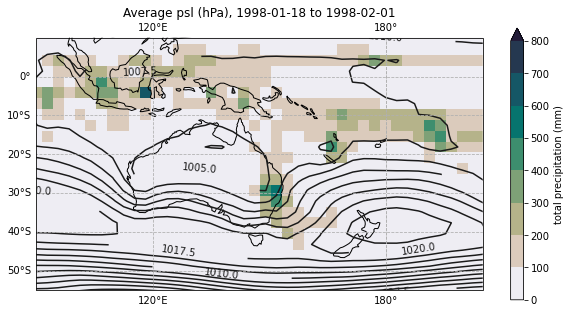

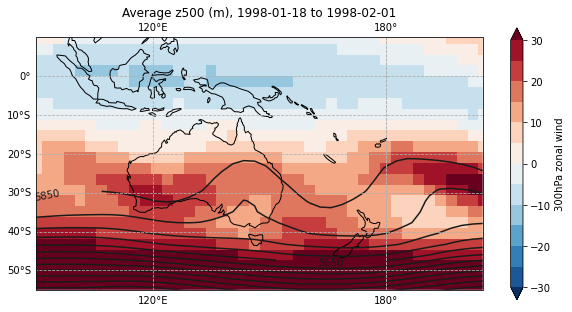

1965 (1971-02-27), ensemble: r2, 345.0907202690974mm


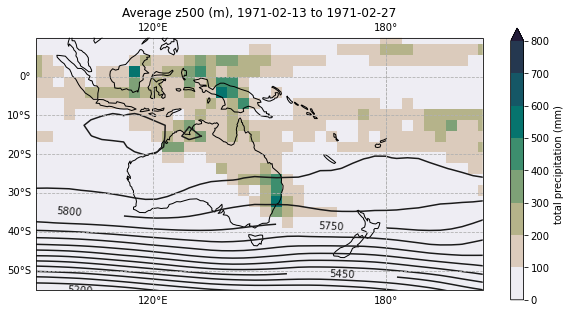

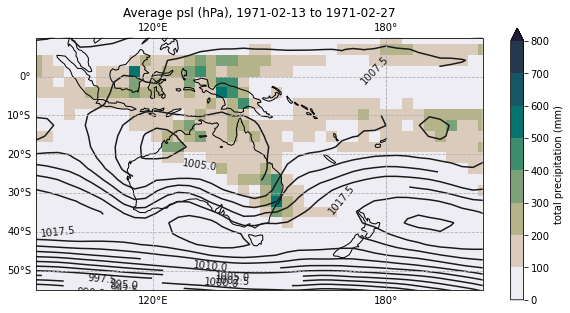

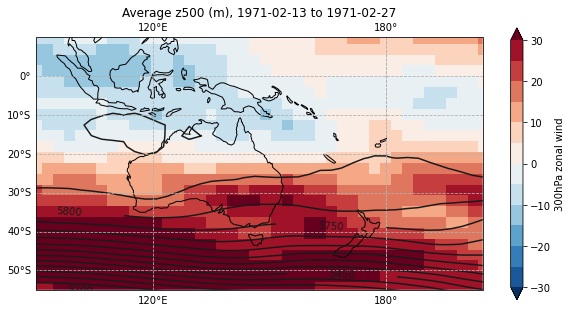

1976 (1982-02-05), ensemble: r3, 341.56060746484184mm


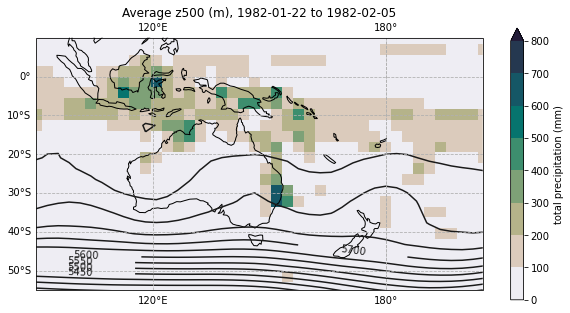

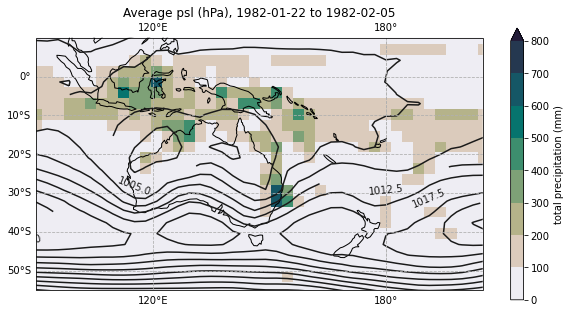

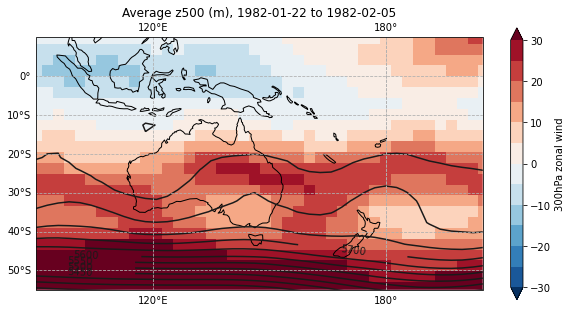

In [71]:
for index, row in ranked_events.head(n=4).iterrows():
    init_date = int(row['init_date'].strftime('%Y')) - 1
    ensemble = int(row['ensemble']) + 1
    end_date = row['event_time']
    rx_value = row['pr']
    print(f'{init_date} ({end_date}), ensemble: r{ensemble}, {rx_value}mm')
    
    start_datetime = datetime.datetime.strptime(end_date, "%Y-%m-%d") - datetime.timedelta(days=14)
    start_date = start_datetime.strftime("%Y-%m-%d")
    
    pr_file = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/CCCma/CanESM5/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/pr/gn/v20190429/*.nc')[0]
    ds_pr = fileio.open_dataset(pr_file, variables=['pr'],)
    
    psl_file = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/CCCma/CanESM5/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/psl/gn/v20190429/*.nc')[0]
    ds_psl = fileio.open_dataset(psl_file, variables=['psl'],)
    
    zg_file = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/CCCma/CanESM5/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/zg/gn/v20190429/*.nc')[0]
    ds_zg = fileio.open_dataset(zg_file, variables=['zg'],)
    
    ua_file = glob.glob(f'/g/data/oi10/replicas/CMIP6/DCPP/CCCma/CanESM5/dcppA-hindcast/s{init_date}-r{ensemble}i1p2f1/day/ua/gn/v20190429/*.nc')[0]
    ds_ua = fileio.open_dataset(ua_file, variables=['ua'],)
    
    zg_da = ds_zg.sel({'time': slice(start_date, end_date)})['zg']
    z500_da = zg_da.sel({'plev': 50000}, method='nearest')
    pr_da = ds_pr.sel({'time': slice(start_date, end_date)})['pr']
    pr_da = xc.units.convert_units_to(pr_da, 'mm d-1')
    psl_da = ds_psl.sel({'time': slice(start_date, end_date)})['psl']
    psl_da = xc.units.convert_units_to(psl_da, 'hPa')
    ua_da = ds_ua.sel({'time': slice(start_date, end_date)})['ua']
    ua300_da = ua_da.sel({'plev': 30000}, method='nearest')

    z500_da_mean = z500_da.mean('time', keep_attrs=True)
    pr_da_sum = pr_da.sum('time', keep_attrs=True)
    psl_da_mean = psl_da.mean('time', keep_attrs=True)
    ua300_da_mean = ua300_da.mean('time', keep_attrs=True) 

    plot_average(pr_da_sum, 'pr', z500_da_mean, 'z500', start_date, end_date)
    plot_average(pr_da_sum, 'pr', psl_da_mean, 'psl', start_date, end_date)
    plot_average(ua300_da_mean, 'ua300', z500_da_mean, 'z500', start_date, end_date)